In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
from scipy.stats import binned_statistic_2d
from sklearn.preprocessing import StandardScaler
import re

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import PReLU

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from tensorflow.keras.losses import Huber
from tensorflow.keras.activations import swish

from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Dense, BatchNormalization, MultiHeadAttention, LayerNormalization, Dropout, Add, Reshape, Flatten, LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling1D

from tensorflow.keras.utils import plot_model




In [15]:
matchedYears = pd.read_csv("/kaggle/input/neighbourstatsv3/matchedTreesInputsStandardizedMedMatching.csv")
scaler = StandardScaler()
tCol = []
for col in matchedYears.columns:
    if "Norm" in col:
        tCol.append(col)
print(tCol)

['TreePosXNorm', 'TreePosYNorm', 'Neighbour Mean AngleNorm', 'Canopy CoverageNorm', 'TreePosZNorm', 'CrownDiameter(metre)Norm', 'CrownDiameter(S-N)(metre)Norm', 'CrownDiameter(E-W)(metre)Norm', 'CrownArea(square metre)Norm', 'CrownVolume(cubic metre)Norm', 'No of Neighbouring TreesNorm', 'Neighbour Mean HeightNorm', 'Neighbour max HeightNorm', 'Neighbour min HeightNorm', 'Neighbour Mean LocationNorm', 'Neighbour Mean Crown AreaNorm', 'Neighbour Max Crown AreaNorm', 'Neighbour Mix Crown AreaNorm', 'LAINorm', 'Top HeightNorm', 'AgeNorm', 'YCNorm', 'meanDBHNorm', 'Basal AreaNorm', 'Vol HaNorm']


In [16]:
print(matchedYears.columns.values)

['Unnamed: 0' 'TreeID' 'TreePosX' 'TreePosY' 'TreePosZ'
 'TreeHeight(metre)' 'DBH(metre)' 'CrownDiameter(metre)'
 'CrownDiameter(S-N)(metre)' 'CrownDiameter(E-W)(metre)'
 'CrownArea(square metre)' 'CrownVolume(cubic metre)' 'OldID' 'FutureZ'
 'FutureCrown' 'FutureArea' 'MatchedID' 'Canopy Coverage' 'LAI'
 'Top Height' 'Age' 'YC' 'meanDBH' 'Basal Area' 'Vol Ha'
 'No of Neighbouring Trees' 'Neighbour Mean Height' 'Neighbour max Height'
 'Neighbour min Height' 'Neighbour Mean Location' 'Neighbour Mean Angle'
 'Neighbour Mean Crown Area' 'Neighbour Max Crown Area'
 'Neighbour Min Crown Area' 'TreePosXNorm' 'TreePosYNorm'
 'Neighbour Mean AngleNorm' 'Canopy CoverageNorm' 'TreePosZNorm'
 'CrownDiameter(metre)Norm' 'CrownDiameter(S-N)(metre)Norm'
 'CrownDiameter(E-W)(metre)Norm' 'CrownArea(square metre)Norm'
 'CrownVolume(cubic metre)Norm' 'No of Neighbouring TreesNorm'
 'Neighbour Mean HeightNorm' 'Neighbour max HeightNorm'
 'Neighbour min HeightNorm' 'Neighbour Mean LocationNorm'
 'Neighbou

In [ ]:
matchedYears = matchedYears[(matchedYears["FutureZ"] != 0) & (matchedYears["FutureCrown"] > 1) & (matchedYears["CrownArea(square metre)"] > 1) & (matchedYears["FutureArea"] != 0)]



matchedYears["heightDiff"] = matchedYears["FutureZ"] - matchedYears["TreePosZ"]
matchedYears["crownDiaDiff"] = matchedYears["FutureCrown"] - matchedYears["CrownDiameter(metre)"]
matchedYears["crownAreaDiff"] = matchedYears["FutureArea"] - matchedYears["CrownArea(square metre)"]

matchedYears = matchedYears[matchedYears["heightDiff"] > -0.5]
#Assuming trees that are shorter over the year is mismatched



for col in matchedYears.columns:
    if isinstance(matchedYears[col].dtype, pd.SparseDtype):
        print(f"Column {col} is sparse!")

In [ ]:
matchedYears["CrownArea(square metre)"].hist()
matchedYears["FutureArea"].hist(alpha = 0.5)

In [ ]:
matchedYears["crownAreaDiff"].hist()

In [ ]:
plt.scatter(matchedYears["CrownDiameter(metre)"]**2*0.8, matchedYears["CrownArea(square metre)"])

In [ ]:
matchedYears[matchedYears["CrownArea(square metre)"] == 0]

In [ ]:
total = len(matchedYears)
split = math.floor(total * 0.8)

shuffled = matchedYears.sample(frac=1)

train = shuffled.iloc[:split]
test = shuffled.iloc[split:]


train_x = train[tCol]
test_x = test[tCol]


trainFutureZ = train["FutureZ"]
trainCrownArea = train["FutureArea"]

trainDiffZ = train["heightDiff"]
trainDiffArea = train["crownAreaDiff"]

testFutureZ = test["FutureZ"]
testCrownArea = test["FutureArea"]

testDiffZ = test["heightDiff"]
testDiffArea = test["crownAreaDiff"]


# One scaler per output
scaler_z = StandardScaler()
scaler_area = StandardScaler()
scaler_diffz = StandardScaler()
scaler_diffarea = StandardScaler()

# Fit on training data
trainFutureZNorm = scaler_z.fit_transform(trainFutureZ.values.reshape(-1, 1))
trainCrownAreaNorm = scaler_area.fit_transform(trainCrownArea.values.reshape(-1, 1))

trainDiffZNorm = scaler_diffz.fit_transform(trainDiffZ.values.reshape(-1, 1))
trainDiffAreaNorm = scaler_diffarea.fit_transform(trainDiffArea.values.reshape(-1, 1))

# Fit scalers on training data
trainDiffZNorm = scaler_diffz.fit_transform(trainDiffZ.values.reshape(-1, 1))
trainDiffAreaNorm = scaler_diffarea.fit_transform(trainDiffArea.values.reshape(-1, 1))

# Use the same scaler to transform test data
testFutureZNorm = scaler_z.transform(test["FutureZ"].values.reshape(-1, 1))
testCrownAreaNorm = scaler_area.transform(test["FutureArea"].values.reshape(-1, 1))

testDiffZNorm = scaler_diffz.transform(test["heightDiff"].values.reshape(-1, 1))
testDiffAreaNorm = scaler_diffarea.transform(test["crownAreaDiff"].values.reshape(-1, 1))


# Assign with correct shape from the beginning
selected_x_train = train_x.to_numpy()
selected_y_train = trainFutureZ  # already (N, 1)

selected_x_test = test_x.to_numpy()
selected_y_test = testFutureZ  # already (N, 1)

# height or crown
target = "height"

epochMax = 3





for col in matchedYears.columns:
    if isinstance(matchedYears[col].dtype, pd.SparseDtype):
        print(f"Column {col} is sparse!")


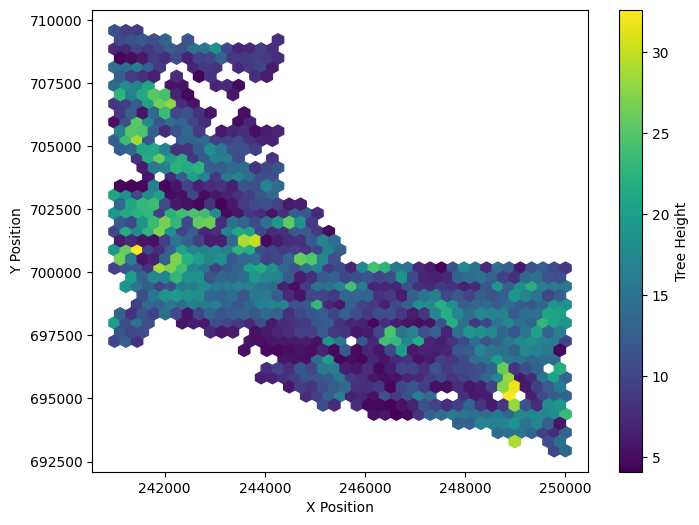

In [8]:
vmin = 0
vmax = 100  # Adjust as needed based on your data (50% relative error cap)

# Hexbin plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    matchedYears["TreePosX"], matchedYears["TreePosY"],
    C=matchedYears["TreePosZ"],
    gridsize=40, cmap="viridis",
    reduce_C_function=np.mean
    #vmin=vmin, vmax=vmax
)

plt.colorbar(hb, label=f"Tree Height")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title(f"")
plt.show()


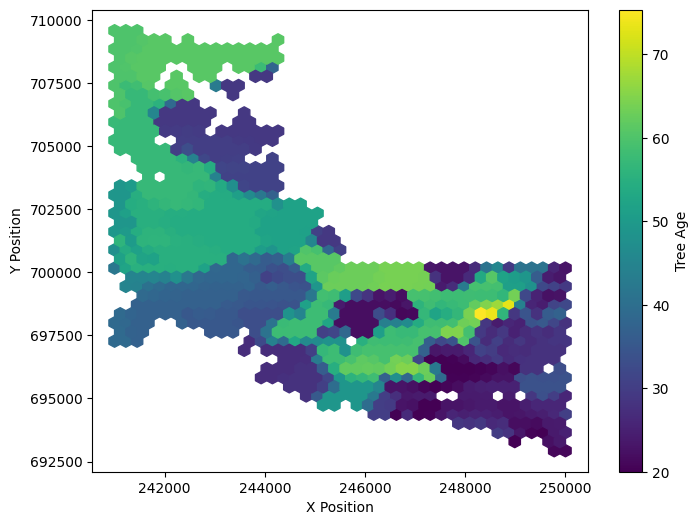

In [11]:
vmin = 0
vmax = 100  # Adjust as needed based on your data (50% relative error cap)

# Hexbin plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    matchedYears["TreePosX"], matchedYears["TreePosY"],
    C=matchedYears["Age"],
    gridsize=40, cmap="viridis",
    reduce_C_function=np.mean
    #vmin=vmin, vmax=vmax
)

plt.colorbar(hb, label=f"Tree Age")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title(f"")
plt.show()


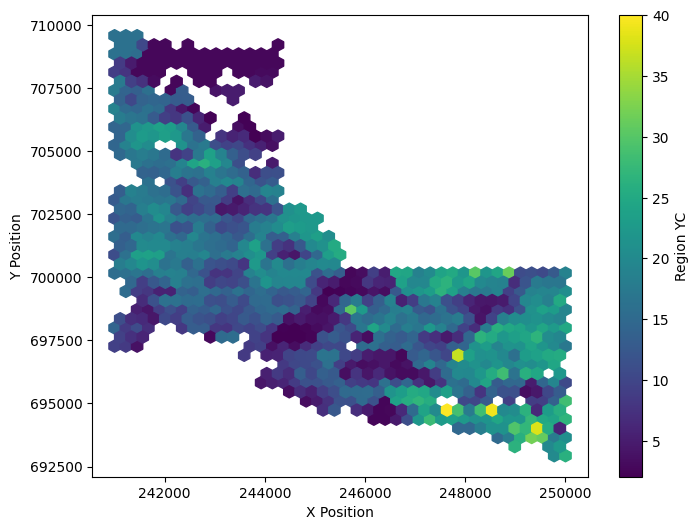

In [14]:
vmin = 0
vmax = 100  # Adjust as needed based on your data (50% relative error cap)

# Hexbin plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    matchedYears["TreePosX"], matchedYears["TreePosY"],
    C=matchedYears["YC"],
    gridsize=40, cmap="viridis",
    reduce_C_function=np.mean
    #vmin=vmin, vmax=vmax
)

plt.colorbar(hb, label=f"Region YC")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title(f"")
plt.show()


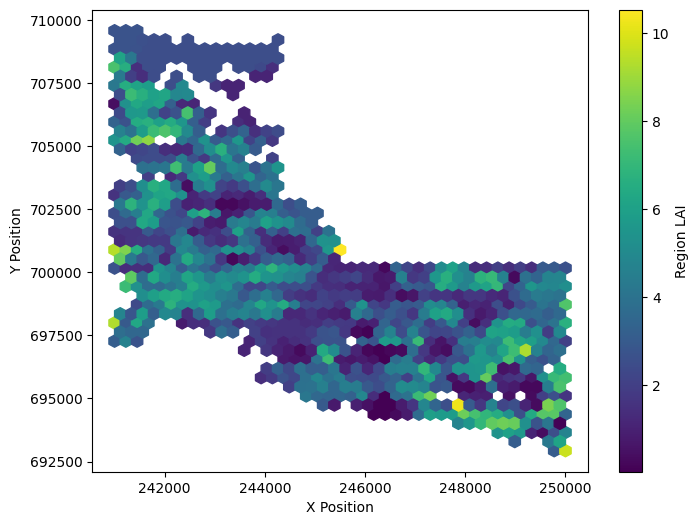

In [18]:
vmin = 0
vmax = 100  # Adjust as needed based on your data (50% relative error cap)

# Hexbin plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    matchedYears["TreePosX"], matchedYears["TreePosY"],
    C=matchedYears["LAI"],
    gridsize=40, cmap="viridis",
    reduce_C_function=np.mean
    #vmin=vmin, vmax=vmax
)

plt.colorbar(hb, label=f"Region LAI")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title(f"")
plt.show()


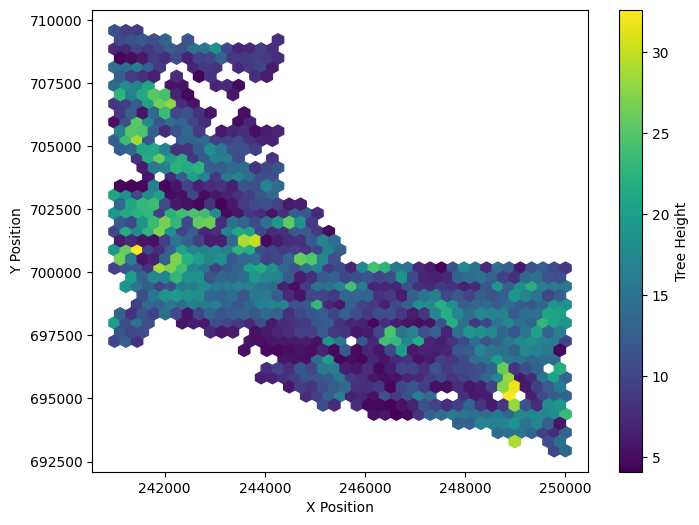

In [21]:
vmin = 0
vmax = 100  # Adjust as needed based on your data (50% relative error cap)

# Hexbin plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    matchedYears["TreePosX"], matchedYears["TreePosY"],
    C=matchedYears["TreePosZ"],
    gridsize=40, cmap="viridis",
    reduce_C_function=np.mean
    #vmin=vmin, vmax=vmax
)

plt.colorbar(hb, label=f"Tree Height")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title(f"")
plt.show()


In [ ]:
heightMean = matchedYears["FutureZ"].mean()
heightDev = matchedYears["FutureZ"].std()

areaMean = matchedYears["FutureArea"].mean()
areaDev = matchedYears["FutureArea"].std()

volMean = matchedYears["CrownVolume(cubic metre)"].mean()
volDev = matchedYears["CrownVolume(cubic metre)"].std()

heightDiffMean = matchedYears["heightDiff"].mean()
heightDiffDev = matchedYears["heightDiff"].std()

diaDiffMean = matchedYears["crownDiaDiff"].mean()
diaDiffDev = matchedYears["crownDiaDiff"].std()

areaDiffMean = matchedYears["crownAreaDiff"].mean()
areaDiffDev = matchedYears["crownAreaDiff"].std()

xMean = matchedYears["TreePosX"].mean()
xDev = matchedYears["TreePosX"].std()

yMean = matchedYears["TreePosY"].mean()
yDev = matchedYears["TreePosY"].std()

In [ ]:
def relative_crown_area_loss(y_true, y_pred, epsilon=1e-6):
    """
    Custom loss that computes the relative error on crown area after unnormalization.
    
    y_true: Tensor of shape (batch_size, 2)
        y_true[:, 0] should be the baseline (current) crown area (un-normalized).
        y_true[:, 1] should be the normalized crown area difference.
    y_pred: Tensor of shape (batch_size, 1) (or shape matching the crown area diff prediction)
        The predicted normalized crown area difference.
    
    Assumes you have global variables `diff_mean` and `diff_std` that were used for normalization.
    """
    # Unnormalize the true crown area difference
    true_diff = y_true[:, 1] * areaDiffDev + areadDiffMean
    # Unnormalize the predicted crown area difference
    pred_diff = y_pred[:, 0] * diff_std + diff_mean

    # Compute the predicted crown area by adding the baseline crown area.
    pred_crown_area = y_true[:, 0] + pred_diff
    true_crown_area = y_true[:, 0] + true_diff

    # Calculate the relative error: |pred - true| / (|true| + epsilon)
    rel_error = tf.abs(pred_crown_area - true_crown_area) / (tf.abs(true_crown_area) + epsilon)
    return tf.reduce_mean(rel_error)


In [ ]:


print("Train X Shape:", selected_x_train.shape)  # Should be (num_samples, num_features)
print("Train Y Shape:", selected_y_train.shape)  # Should be (num_samples, 2)


In [ ]:
# Swish Activation Models

brickMish = Sequential([
    Dense(512, activation='mish'),
    Dropout(0.01),
    Dense(512, activation='mish'),
    Dropout(0.01),
    Dense(512, activation='mish'),
    
    Dense(512, activation='mish'),
    
    Dense(512, activation='mish'),
    
    Dense(1, activation="linear")  
])

funnelMish = Sequential([
    Dense(512, activation='mish'),
    Dropout(0.01),
    Dense(512, activation='mish'),
    Dropout(0.01),
    Dense(256, activation='mish'),
    
    Dense(256, activation='mish'),
    
    Dense(128, activation='mish'),
    
    Dense(128, activation='mish'),
    
    Dense(64, activation='mish'),
    
    Dense(64, activation='mish'),
    
    Dense(1, activation="linear")  
])

bottleMish = Sequential([
    Dense(512, activation='mish'),
    Dropout(0.01),
    Dense(512, activation='mish'),
    Dropout(0.01),
    Dense(256, activation='mish'),
    
    Dense(128, activation='mish'),
    
    Dense(256, activation='mish'),
    
    Dense(512, activation='mish'),
    
    Dense(1, activation="linear")  
])

# Smaller Versions of the Models



In [ ]:
brickElu = Sequential([
    Dense(512, activation='elu'),
    Dropout(0.01),
    Dense(512, activation='elu'),
    Dropout(0.01),
    Dense(512, activation='elu'),
    
    Dense(512, activation='elu'),
    
    Dense(512, activation='elu'),
    
    Dense(1, activation="linear")  
])

funnelElu = Sequential([
    Dense(512, activation='elu'),
    Dropout(0.01),
    Dense(512, activation='elu'),
    Dropout(0.01),
    Dense(256, activation='elu'),
    
    Dense(256, activation='elu'),
    
    Dense(128, activation='elu'),
    
    Dense(128, activation='elu'),
    
    Dense(64, activation='elu'),
    
    Dense(64, activation='elu'),
    
    Dense(1, activation="linear")  
])

bottleElu = Sequential([
    Dense(512, activation='elu'),
    Dropout(0.01),
    Dense(512, activation='elu'),
    Dropout(0.01),
    Dense(256, activation='elu'),
    
    Dense(128, activation='elu'),
    
    Dense(256, activation='elu'),
    
    Dense(512, activation='elu'),
    
    Dense(1, activation="linear")  
])

In [ ]:
brickSigmoid = Sequential([
    Dense(512, activation='sigmoid'),
    Dropout(0.01),
    Dense(512, activation='sigmoid'),
    Dropout(0.01),
    Dense(512, activation='sigmoid'),
    
    Dense(512, activation='sigmoid'),
    
    Dense(512, activation='sigmoid'),
    
    Dense(1, activation="linear")  
])

funnelSigmoid = Sequential([
    Dense(512, activation='sigmoid'),
    Dropout(0.01),
    Dense(512, activation='sigmoid'),
    Dropout(0.01),
    Dense(256, activation='sigmoid'),
    
    Dense(256, activation='sigmoid'),
    
    Dense(128, activation='sigmoid'),
    
    Dense(128, activation='sigmoid'),
    
    Dense(64, activation='sigmoid'),
    
    Dense(64, activation='sigmoid'),
    
    Dense(1, activation="linear")  
])

bottleSigmoid = Sequential([
    Dense(512, activation='sigmoid'),
    Dropout(0.01),
    Dense(512, activation='sigmoid'),
    Dropout(0.01),
    Dense(256, activation='sigmoid'),
    
    Dense(128, activation='sigmoid'),
    
    Dense(256, activation='sigmoid'),
    
    Dense(512, activation='sigmoid'),
    
    Dense(1, activation="linear")  
])

In [ ]:
#Prelu models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, PReLU

# Brick Prelu
brickPrelu = Sequential([
    Dense(512),
    PReLU(),
    Dropout(0.01),
    Dense(512),
    PReLU(),
    Dropout(0.01),
    Dense(512),
    PReLU(),
    Dense(512),
    PReLU(),
    Dense(512),
    PReLU(),
    Dense(1, activation="linear")  
])

# Funnel Prelu
funnelPrelu = Sequential([
    Dense(512),
    PReLU(),
    Dropout(0.01),
    Dense(512),
    PReLU(),
    Dropout(0.2),
    Dense(256),
    PReLU(),
    Dense(256),
    Dropout(0.4),
    PReLU(),
    Dense(128),
    PReLU(),
    Dense(128),
    PReLU(),
    Dense(64),
    PReLU(),
    Dense(64),
    PReLU(),
    Dense(1, activation="linear")  
])

# Bottle Prelu
bottlePrelu = Sequential([
    Dense(512),
    PReLU(),
    Dropout(0.01),
    Dense(512),
    PReLU(),
    Dropout(0.01),
    Dense(256),
    PReLU(),
    Dense(128),
    PReLU(),
    Dense(256),
    PReLU(),
    Dense(512),
    PReLU(),
    Dense(1, activation="linear")  
])

linear = Sequential([
    Dense(1, activation="linear")  
])

brickPreluSmall = Sequential([
    Dense(256),  # Reduced neurons
    
    PReLU(),
    Dense(256),  # Reduced neurons
    
    PReLU(),
    Dense(128),  # Reduced neurons
    
    PReLU(),
    Dense(128),  # Reduced neurons
    
    PReLU(),
    Dense(1, activation="linear")  # Output layer remains the same
])


funnelPreluSmall = Sequential([
    Dense(256),  # Reduced neurons
    
    PReLU(),
    Dense(256),  # Reduced neurons
    
    PReLU(),
    Dense(128),  # Reduced neurons
    
    PReLU(),
    Dense(128),  # Reduced neurons
    
    PReLU(),
    Dense(64),  # Reduced neurons
    
    PReLU(),
    Dense(64),  # Reduced neurons
    
    PReLU(),
    Dense(1, activation="linear")  # Output layer remains the same
])

bottlePreluSmall = Sequential([
    Dense(256),  # Reduced neurons
    
    PReLU(),
    Dense(256),  # Reduced neurons
    
    PReLU(),
    Dense(128),  # Reduced neurons
    
    PReLU(),
    Dense(128),  # Reduced neurons
    
    PReLU(),
    Dense(256),  # Reduced neurons
    
    PReLU(),
    Dense(256),  # Reduced neurons
    
    PReLU(),
    Dense(1, activation="linear")  # Output layer remains the same
])




In [ ]:
#Attention
# Define input
input_layer = Input(shape=(train_x.shape[1],))  # (batch, features)

# Initial Dense Layer
x = Dense(512, activation=LeakyReLU(alpha=0.01))(input_layer)
x = BatchNormalization()(x)

# Reshape for attention (batch, seq_len=1, features)
x = Reshape((1, 512))(x)  

# Multi-Head Self-Attention Layer         4          32
attention = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)  # (batch, 1, features)
attention = Add()([x, attention])  # Residual connection
attention = LayerNormalization()(attention)  

# Flatten back to (batch, features)
x = Flatten()(attention)  

# Dense Layers for Final Prediction
x = Dense(512, activation=LeakyReLU(alpha=0.01))(x)
x = BatchNormalization()(x)
x = Dense(512, activation=LeakyReLU(alpha=0.01))(x)
x = BatchNormalization()(x)
x = Dense(256, activation=LeakyReLU(alpha=0.01))(x)
x = BatchNormalization()(x)
x = Dense(256, activation=LeakyReLU(alpha=0.01))(x)
x = BatchNormalization()(x)
x = Dense(128, activation=LeakyReLU(alpha=0.01))(x)
x = BatchNormalization()(x)

# Output Layer (Predicting height and crown area differences)
output_layer = Dense(2, activation="linear")(x)  

# Define and Compile Model
attention_model = Model(inputs=input_layer, outputs=output_layer)



In [ ]:
def build_custom_funnel():
    # Input Layer
    input_layer = Input(shape=(22,))  # 22 features
    
    # Reshape FIRST to (22, 1) before projection
    x = Reshape((22, 1))(input_layer)  # New shape: (batch, 22, 1)
    
    # Project each feature to 512D
    x = Dense(512//2, activation=LeakyReLU(alpha=0.01))(x)  # Now shape: (batch, 22, 512)
    x = BatchNormalization()(x)
    
    # First Attention Block
    attn_input1 = x
    attn_output1 = MultiHeadAttention(num_heads=8, key_dim=64)(attn_input1, attn_input1)
    x = Add()([attn_input1, attn_output1])
    x = LayerNormalization()(x)
    
    # Feature Reduction Block 1
    x = Dense(256//2, activation=LeakyReLU(alpha=0.01))(x)  # (batch, 22, 256)
    x = BatchNormalization()(x)
    
    # Second Attention Block
    attn_input2 = x
    attn_output2 = MultiHeadAttention(num_heads=2, key_dim=32)(attn_input2, attn_input2)
    x = Add()([attn_input2, attn_output2])
    x = LayerNormalization()(x)
    
    # Final Feature Reduction
    x = Dense(128//2, activation=LeakyReLU(alpha=0.01))(x)  # (batch, 22, 128)
    x = BatchNormalization()(x)
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)  # (batch, 128)
    
    # Dense Head
    x = Dense(512//2, activation=LeakyReLU(alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(256//2, activation=LeakyReLU(alpha=0.01))(x)
    x = BatchNormalization()(x)
    
    # Output Layer
    output_layer = Dense(2, activation="linear")(x)
    
    return Model(inputs=input_layer, outputs=output_layer)

bottleneck = build_custom_funnel()

In [ ]:
#Attention
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Lambda
import tensorflow as tf

def build_attention_model(input_dim, num_heads=4, ff_dim=256, num_attention_layers=3):
    inputs = Input(shape=(input_dim,))
    
    # Convert 1D input to 2D sequence (batch_size, sequence_length=1, features)
    x = Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
    
    # Project input to higher dimension for attention
    x = Dense(ff_dim)(x)  # Now shape: (batch_size, 1, ff_dim)
    
    for _ in range(num_attention_layers):
        # Residual connection 1
        attn_input = x
        
        # Multi-Head Attention
        attn_output = MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=ff_dim // num_heads
        )(attn_input, attn_input)
        
        # Add & Norm
        x = LayerNormalization()(attn_output + attn_input)
        
        # Feed Forward
        ff_input = x
        x = Dense(ff_dim, activation=LeakyReLU(alpha=0.01))(x)
        
        # Add & Norm
        x = LayerNormalization()(x + ff_input)

    # Final processing
    x = Lambda(lambda x: tf.reduce_mean(x, axis=1), output_shape=(ff_dim,))(x)
    outputs = Dense(2, activation="linear")(x)
    
    return Model(inputs, outputs)

# Usage
moreAtt = build_attention_model(22, num_attention_layers=12)  # 22 input features

In [ ]:
def build_attention_Funnel(
    input_dim,
    num_heads=4,
    ff_dim=256,
    num_attention_layers=3,
    acti=tf.keras.layers.LeakyReLU(negative_slope=0.01),
):
    inputs = Input(shape=(input_dim,))
    
    # Reshape input into sequence of features: (batch_size, input_dim, 1)
    x = Lambda(lambda x: tf.expand_dims(x, axis=-1), output_shape=(input_dim, 1))(inputs)
    
    # Project features into embedding dimension
    x = Dense(ff_dim)(x)
    
    for i in range(num_attention_layers):
        attn_input = x
        
        # Multi-Head Attention
        attn_output = MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=ff_dim // num_heads
        )(attn_input, attn_input)
        
        # Add & Norm
        x = LayerNormalization()(attn_output + attn_input)
        
        # Feed-Forward Network
        ff_input = x
        x = Dense(ff_dim, activation=acti)(x)
        x = Dense(ff_dim)(x)
        x = Dense(ff_dim)(x)
        
        
        # Project residual if needed
        if ff_input.shape[-1] != x.shape[-1]:
            ff_input = Dense(ff_dim)(ff_input)
        
        # Add & Norm
        x = LayerNormalization()(x + ff_input)
        
        # Reduce ff_dim every layer
        new_ff_dim = int(max(ff_dim / 2, 64))
        if new_ff_dim != ff_dim:
            x = Dense(new_ff_dim)(x)
        ff_dim = new_ff_dim

    # Global average pooling with specified output shape
    x = Lambda(lambda x: tf.reduce_mean(x, axis=1), output_shape=(ff_dim,))(x)
    outputs = Dense(2, activation=acti)(x)
    
    return Model(inputs, outputs)


#attFunnel = build_attention_Funnel(22, num_attention_layers=12, ff_dim=512)  # 22 input features
#attSwishFunnel = build_attention_Funnel(22, num_attention_layers=12, ff_dim=512, acti="swish")  
#moreHeads = build_attention_Funnel(22, num_attention_layers=2, ff_dim=128, num_heads=2)  
softplusAtt = build_attention_Funnel(22, num_attention_layers=2, ff_dim=128, num_heads=2, acti="softplus")  

In [ ]:


targetModel = linear
modelTitle = "linearCrownRelErrKNN"

optimizer = Adam(learning_rate=1e-5)

reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-12)
early_stop = EarlyStopping(monitor="val_loss", patience=24, min_delta=0.0001, restore_best_weights=True)


def quantile_loss(q, y_true, y_pred):
    error = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * error, (q - 1) * error))

def relative_error_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-6)))  # Adding small value to avoid division by zero


quantLoss = lambda y_true, y_pred: quantile_loss(0.5, y_true, y_pred)
relError = lambda y_true, y_pred: relative_error_loss(y_true, y_pred)
relErrNormalized = lambda y_true, y_pred: relErrNorm(y_true, y_pred)
mseLoss = "mse"
huber = Huber(delta=1.0)
hybridLoss = lambda y_true, y_pred: 0.7 * quantile_loss(0.5, y_true, y_pred) + 0.3 * relative_error_loss(y_true, y_pred)


targetModel.compile(optimizer=optimizer, loss=relError)#relative_error_loss)#lambda y_true, y_pred: quantile_loss(0.5, y_true, y_pred))


history = targetModel.fit(selected_x_train, selected_y_train, 
                    epochs=epochMax, 
                    validation_split=0.1, 
                    batch_size=16, 
                    callbacks=[early_stop, reduce_lr_on_plateau],
                    verbose=2)



targetModel.summary()

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [ ]:
class dummyModel:
    def predict_on_batch(self,xs):

        pred = []

        

        for x in xs:
            #fix this
            h = x[2]
    
            
            d = x[3]
            
    
            h = h * heightDev + heightMean
            d = d * diaDev + diaMean
            pred.append([0.0,0.0])
        

        return pred

class dummyModelHeight:
    def predict_on_batch(x):

        print(x)
        #fix this
        h = x[0][2]

        
        d = x[0][3]
        

        h = h * heightDev + heightMean
        d = d * diaDev + diaMean
        

        return [[h]]

In [ ]:
targetModel.evaluate(selected_x_test, selected_y_test, verbose=2)



In [ ]:
def getErrors(model, target):
    assert target in ["height", "crown"], "Target must be 'height' or 'crown'"

    err_test = test.sample(frac=1)

    errtest_x = err_test[tCol]
    
    truePoints = err_test[["TreePosX", "TreePosY"]]

    errtest_x = errtest_x.to_numpy()

    # Get true values for the specific target
    if target == "height":
        true_y = err_test["FutureZ"].to_numpy()
    else:  # "crown"
        true_y = err_test["FutureArea"].to_numpy()

    predictions = model.predict_on_batch(errtest_x).flatten()

    # Compute R² and errors
    r2 = r2_score(true_y, predictions)

    total_error = 0
    relative_error = 0
    relativeErrorPlot = []

    for i, pred in enumerate(predictions):
        true = true_y[i]
        diff = abs(pred - true)
        perc_diff = diff / true if true != 0 else 0

        x = truePoints.iloc[i, 0]
        y = truePoints.iloc[i, 1]

        relativeErrorPlot.append([x, y, perc_diff, pred, true])

        total_error += diff / len(predictions)
        relative_error += perc_diff / len(predictions)

    # Print results
    if target == "height":
        print(f"R² Score for Height: {round(r2, 4)}")
        print(f"Height error is ±{round(total_error, 2)}m")
        print(f"Relative height error: {round(relative_error * 100, 2)}%")
        return pd.DataFrame(relativeErrorPlot, columns=["x", "y", "HeightError", "PredictedHeight", "TrueHeight"])
    
    else:
        print(f"R² Score for Crown Area: {round(r2, 4)}")
        print(f"Crown Area error is ±{round(total_error, 2)}m²")
        print(f"Relative crown area error: {round(relative_error * 100, 2)}%")
        return pd.DataFrame(relativeErrorPlot, columns=["x", "y", "CrownAreaError", "PredictedArea", "TrueArea"])


In [ ]:
def getErrorsDiff(model, target):
    assert target in ["height", "crown"], "Target must be 'height' or 'crown'"

    err_test = test.sample(frac=1)

    errtest_x = err_test[tCol]
    
    truePoints = err_test[["TreePosX", "TreePosY"]]

    errtest_x = errtest_x.to_numpy()

    # Get true values for the specific target
    if target == "height":
        true_y = err_test["FutureZ"].to_numpy()
    else:  # "crown"
        true_y = err_test["FutureArea"].to_numpy()

    predictions = model.predict_on_batch(errtest_x).flatten()

    # Un-normalize
    if target == "height":
        predictions = err_test["TreePosZ"] + predictions 
    else:  # "crown"
        predictions = err_test["CrownArea(square metre)"] + predictions 

    # Compute R² and errors
    r2 = r2_score(true_y, predictions)

    total_error = 0
    relative_error = 0
    relativeErrorPlot = []

    for i, pred in enumerate(predictions):
        true = true_y[i]
        diff = abs(pred - true)
        perc_diff = diff / true if true != 0 else 0

        x = truePoints.iloc[i, 0]
        y = truePoints.iloc[i, 1]

        relativeErrorPlot.append([x, y, perc_diff, pred, true])

        total_error += diff / len(predictions)
        relative_error += perc_diff / len(predictions)

    # Print results
    if target == "height":
        print(f"R² Score for Height: {round(r2, 4)}")
        print(f"Height error is ±{round(total_error, 2)}m")
        print(f"Relative height error: {round(relative_error * 100, 2)}%")
        return pd.DataFrame(relativeErrorPlot, columns=["x", "y", "HeightError", "PredictedHeight", "TrueHeight"])
    
    else:
        print(f"R² Score for Crown Area: {round(r2, 4)}")
        print(f"Crown Area error is ±{round(total_error, 2)}m²")
        print(f"Relative crown area error: {round(relative_error * 100, 2)}%")
        return pd.DataFrame(relativeErrorPlot, columns=["x", "y", "CrownAreaError", "PredictedArea", "TrueArea"])


In [ ]:
def getErrorsNorm(model, target):
    assert target in ["height", "crown"], "Target must be 'height' or 'crown'"

    err_test = test.sample(frac=1)

    errtest_x = err_test[tCol]
    
    truePoints = err_test[["TreePosX", "TreePosY"]]

    errtest_x = errtest_x.to_numpy()

    # Get true values for the specific target
    if target == "height":
        true_y = err_test["FutureZ"].to_numpy()
    else:  # "crown"
        true_y = err_test["FutureArea"].to_numpy()

    predictions = model.predict_on_batch(errtest_x).flatten()

    # Un-normalize
    if target == "height":
        predictions = predictions * heightDev + heightMean
    else:  # "crown"
        predictions = predictions * areaDev + areaMean

    # Compute R² and errors
    r2 = r2_score(true_y, predictions)

    total_error = 0
    relative_error = 0
    relativeErrorPlot = []

    for i, pred in enumerate(predictions):
        true = true_y[i]
        diff = abs(pred - true)
        perc_diff = diff / true if true != 0 else 0

        x = truePoints.iloc[i, 0]
        y = truePoints.iloc[i, 1]

        relativeErrorPlot.append([x, y, perc_diff, pred, true])

        total_error += diff / len(predictions)
        relative_error += perc_diff / len(predictions)

    # Print results
    if target == "height":
        print(f"R² Score for Height: {round(r2, 4)}")
        print(f"Height error is ±{round(total_error, 2)}m")
        print(f"Relative height error: {round(relative_error * 100, 2)}%")
        return pd.DataFrame(relativeErrorPlot, columns=["x", "y", "HeightError", "PredictedHeight", "TrueHeight"])
    
    else:
        print(f"R² Score for Crown Area: {round(r2, 4)}")
        print(f"Crown Area error is ±{round(total_error, 2)}m²")
        print(f"Relative crown area error: {round(relative_error * 100, 2)}%")
        return pd.DataFrame(relativeErrorPlot, columns=["x", "y", "CrownAreaError", "PredictedArea", "TrueArea"])


In [ ]:
def getErrorsDiffNorm(model, target="height"):
    assert target in ["height", "crown"], "Target must be 'height' or 'crown'"

    err_test = test.sample(frac=1)

    errtest_x = err_test[tCol]
    
    truePoints = err_test[["TreePosX", "TreePosY"]]

    errtest_x = errtest_x.to_numpy()

    # Get true values for the specific target
    if target == "height":
        true_y = err_test["FutureZ"].to_numpy()
    else:  # "crown"
        true_y = err_test["FutureArea"].to_numpy()

    predictions = model.predict_on_batch(errtest_x).flatten()

    # Un-normalize
    if target == "height":
        predictions = err_test["TreePosZ"] + (predictions * heightDiffDev + heightDiffMean)
    else:  # "crown"
        predictions = err_test["CrownArea(square metre)"] + (predictions * areaDiffDev + areaDiffMean)

    # Compute R² and errors
    r2 = r2_score(true_y, predictions)

    total_error = 0
    relative_error = 0
    relativeErrorPlot = []

    for i, pred in enumerate(predictions):
        true = true_y[i]
        diff = abs(pred - true)
        perc_diff = diff / true if true != 0 else 0

        x = truePoints.iloc[i, 0]
        y = truePoints.iloc[i, 1]

        relativeErrorPlot.append([x, y, perc_diff, pred, true])

        total_error += diff / len(predictions)
        relative_error += perc_diff / len(predictions)

    # Print results
    if target == "height":
        print(f"R² Score for Height: {round(r2, 4)}")
        print(f"Height error is ±{round(total_error, 2)}m")
        print(f"Relative height error: {round(relative_error * 100, 2)}%")
        return pd.DataFrame(relativeErrorPlot, columns=["x", "y", "HeightError", "PredictedHeight", "TrueHeight"])
    
    else:
        print(f"R² Score for Crown Area: {round(r2, 4)}")
        print(f"Crown Area error is ±{round(total_error, 2)}m²")
        print(f"Relative crown area error: {round(relative_error * 100, 2)}%")
        return pd.DataFrame(relativeErrorPlot, columns=["x", "y", "CrownAreaError", "PredictedArea", "TrueArea"])


In [ ]:



# Get prediction error table
relativeErrorTable = getErrors(targetModel, target=target)

# Extract average relative error (in percent)
error_col = "HeightError" if target == "height" else "CrownAreaError"
true_col = "TrueHeight" if target == "height" else "TrueArea"
avg_error_percent = round(relativeErrorTable[error_col].mean() * 100, 2)

# Save model and results
filename_prefix = f"{modelTitle}maxEpoch{epochMax}relativeError{target.capitalize()}_{avg_error_percent}perc"

targetModel.save(f"{filename_prefix}.h5")
history_df = pd.DataFrame(history.history)
history_df.to_csv(f"{filename_prefix}History.csv", index=False)
relativeErrorTable.to_csv(f"{filename_prefix}.csv", index=False)

# Set hexbin plot error range
vmin = 0
vmax = 0.75  # Adjust as needed based on your data (50% relative error cap)

# Hexbin plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    relativeErrorTable["x"], relativeErrorTable["y"],
    C=relativeErrorTable[error_col],
    gridsize=40, cmap="viridis",
    reduce_C_function=np.mean,
    vmin=vmin, vmax=vmax
)

plt.colorbar(hb, label=f"Average Relative {target.capitalize()} Error")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title(f"Spatial Distribution of Relative {target.capitalize()} Error")
plt.show()


In [ ]:

plt.hist(relativeErrorTable[error_col], bins=30, color="skyblue", edgecolor="black", alpha=0.7)

In [ ]:
plt.scatter(relativeErrorTable[true_col],relativeErrorTable[error_col], alpha = 0.05)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Determine the column names for the x and y values based on the target
true_col = "TrueHeight" if target == "height" else "TrueArea"
error_col = "HeightError" if target == "height" else "CrownAreaError"

# Plot the joint KDE plot to show density of points
sns.jointplot(x=true_col, y=error_col, data=relativeErrorTable, kind="kde", cmap="Blues")

# Show plot
plt.show()

In [ ]:
# Create a 2D histogram
plt.hist2d(relativeErrorTable[true_col], relativeErrorTable[error_col], bins=50, cmap="viridis")

# Add a color bar to show the point density
plt.colorbar(label="Density")

# Label axes
plt.xlabel(true_col)
plt.ylabel(error_col)

# Show plot
plt.show()
